# Deliverables



1. A report (in the form of a presentation, both verbal and through a slides)


2. A github repository containing your jupyter notebook that walks through the pipeline along with the .py files necessary to reproduce your model.



In [1]:
import wrangle
import pandas as pd
import numpy as np
import evaluate
import explore
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, explained_variance_score
from scipy import stats
import split_scale
import feature_selection
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import QuantileTransformer, quantile_transform
from sklearn.metrics import median_absolute_error, r2_score
from math import sqrt
from sklearn.preprocessing import PolynomialFeatures
from pygam import LinearGAM, s, f, te
from sklearn.linear_model import RidgeCV
from sklearn.compose import TransformedTargetRegressor
from scipy import sparse
import models


In [2]:
#use wrangle.py to import data from mySQL
df =wrangle.get_data_from_sql()

In [3]:
# check DF head
df.head(2)

,bathrooms,bedrooms,square_feet,fips,lot_size,pool,zip_code,year_built,latitude,longitude,assessed_value,tax_value,transaction_date
0,2.0,3.0,1458.0,6037.0,8284.0,1.0,97318.0,1970.0,34686163.0,-118113100.0,136104.0,2319.90,2017-06-23
1,1.0,2.0,1421.0,6037.0,6707.0,NaN,96018.0,1911.0,33999877.0,-118291863.0,35606.0,543.69,2017-06-30


In [4]:
# check DF tail
df.tail(2)

,bathrooms,bedrooms,square_feet,fips,lot_size,pool,zip_code,year_built,latitude,longitude,assessed_value,tax_value,transaction_date
14988,3.0,5.0,2655.0,6059.0,6000.0,NaN,97065.0,1994.0,33836898.0,-117801369.0,746963.0,8065.50,2017-06-30
14989,3.0,4.0,2305.0,6037.0,5742.0,NaN,96129.0,1949.0,33952368.0,-118441155.0,579047.0,6996.21,2017-06-30


In [5]:
# there are null values in lot_size, pool, zip_code, year_built and tax-value
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14990 entries, 0 to 14989
Data columns (total 13 columns):
bathrooms           14990 non-null float64
bedrooms            14990 non-null float64
square_feet         14990 non-null float64
fips                14990 non-null float64
lot_size            14893 non-null float64
pool                3287 non-null float64
zip_code            14982 non-null float64
year_built          14974 non-null float64
latitude            14990 non-null float64
longitude           14990 non-null float64
assessed_value      14990 non-null float64
tax_value           14989 non-null float64
transaction_date    14990 non-null object
dtypes: float64(12), object(1)
memory usage: 1.5+ MB


In [6]:
#wrangle data to remove NANs
df = wrangle.wrangle_zillow()

In [7]:
#create a new column tax-rate
df['tax_rate'] = df.tax_value/df.assessed_value

In [8]:
#https://www.nrcs.usda.gov/wps/portal/nrcs/detail/national/home/?cid=nrcs143_013697
#source for county fips code. Read codes in a data DataFrame named fips_codes
#fips_codes = pd.read_clipboard()

In [9]:
fips_code = pd.DataFrame({
    'fips': [6037, 6059, 6111],
    'County':['Los Angles', 'Orange', 'Ventura']
})
fips_code.head()

,fips,County
0,6037,Los Angles
1,6059,Orange
2,6111,Ventura


In [10]:
#merge df and fips_codes 
df = pd.merge(df, fips_code, left_on='fips', right_on='fips', how='left')

In [11]:
# add some logrithmic variables
df['log2sf'] = np.log2(df['square_feet'])
df['log2lot_size'] = np.log2(df['lot_size'])
df['log2value'] = np.log2(df['assessed_value'])
df['age'] = 2000-df.year_built

In [12]:
#add median home value to each row for corresponding zip_code
zip1 = df.zip_code
list1 = list(zip1)
(df[df.zip_code == list1[3]]).assessed_value.median()

def median_v(df, l):
    list2 = []
    for i in range(0, len(l)):
        median1 = (df[df.zip_code == l[i]]).assessed_value.median()
        list2.append(median1)
    return list2

list3 = median_v(df, list1)
list3 = pd.DataFrame(list3, columns=['zip_median'])
df = pd.concat([df, list3], axis=1)
df['log2_zip_median'] = np.log2(df['zip_median'])

In [13]:
df.head(2)

,bathrooms,bedrooms,square_feet,fips,lot_size,pool,zip_code,year_built,latitude,longitude,...,tax_value,transaction_date,tax_rate,County,log2sf,log2lot_size,log2value,age,zip_median,log2_zip_median
0,2.0,3.0,1458.0,6037,8284,1,97318,1970,34686163.0,-118113100.0,...,2319.90,2017-06-23,0.017045,Los Angles,10.509775,13.016112,17.054350,30,144172.0,17.137431
1,1.0,2.0,1421.0,6037,6707,0,96018,1911,33999877.0,-118291863.0,...,543.69,2017-06-30,0.015270,Los Angles,10.472691,12.711452,15.119833,89,162337.0,17.308632


In [14]:
#split the data into train and test
train, test = train_test_split(df, train_size = .70, random_state = 100)

In [15]:
#create a subset of df with continuous variables to create pairplot
train_plot = train[['bathrooms', 'bedrooms', 'square_feet', 'zip_median', 'assessed_value']]

In [16]:
#df.groupby(['zip_code']).agg(['mean', 'count'])

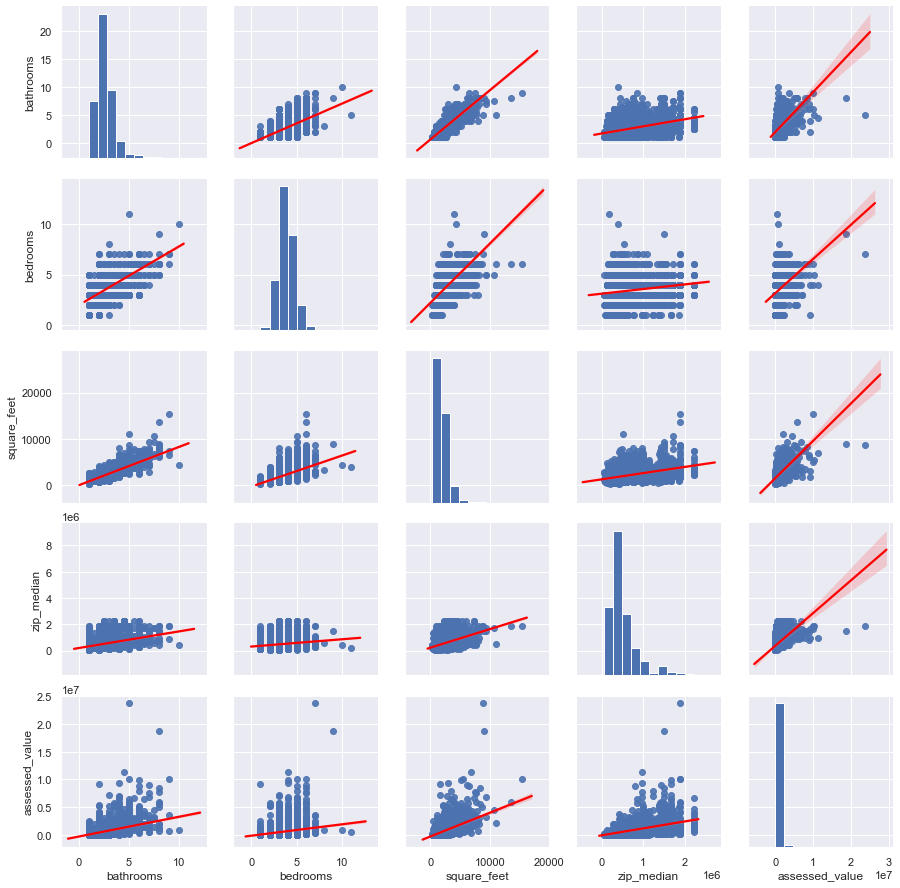

In [17]:
explore.plot_variable_pairs(train_plot)

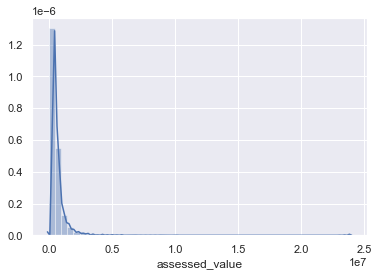

In [18]:
# plot showing distribution of home values. This looks like right skewed distribution
sns.distplot(train.assessed_value)

In [19]:
cm = train_plot.corr()
cm

,bathrooms,bedrooms,square_feet,zip_median,assessed_value
bathrooms,1.000000,0.641827,0.854944,0.401801,0.505229
bedrooms,0.641827,1.000000,0.628387,0.160060,0.263875
square_feet,0.854944,0.628387,1.000000,0.435389,0.588502
zip_median,0.401801,0.160060,0.435389,1.000000,0.558425
assessed_value,0.505229,0.263875,0.588502,0.558425,1.000000


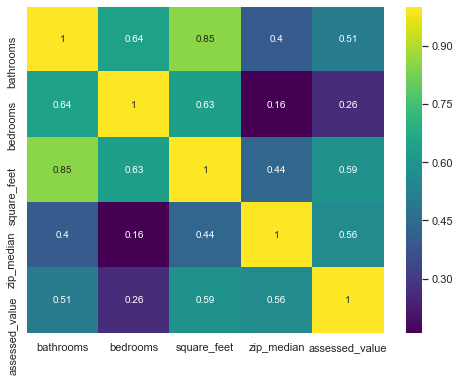

In [20]:
# lets look at heatmap and corresponding correlation values 
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, cmap='viridis')

# $H_0$: there is no relationship between home values and number of bedrooms, bathrooms and square_feet
# $H_a$: There is a relationship between home values and number of bedrooms, bathrooms and square_feet

In [21]:
#Lets take a look at simple model based on bathoom, bedroom and squarefeet and compare if against the baseline(median home value)
X_train = train[['bedrooms', 'bathrooms', 'square_feet']]
y_train = train[['assessed_value']]
X_test = test[['bedrooms', 'bathrooms', 'square_feet']]
y_test = test[['assessed_value']]

In [22]:
# make a dataframe 'predictions' with actual home values
predictions = pd.DataFrame({
    'actual': y_train.assessed_value
})
predictions.head(2)

,actual
11938,268557.0
790,95849.0


In [23]:
predictions['median_bl'] =  train['assessed_value'].median()
predictions['mean_bl'] =  train['assessed_value'].mean()

In [24]:
predictions.head(2)

,actual,median_bl,mean_bl
11938,268557.0,389610.0,543785.23869
790,95849.0,389610.0,543785.23869


In [25]:
#We now create a OLS model based on bedrooms, bathrooms and square_feet
from statsmodels.formula.api import ols

# generate parameters, i.e. create model
ols_model = ols('assessed_value ~ bedrooms + bathrooms + square_feet', data = train).fit()

# compute predictions and add to original dataframe
predictions['ols'] = ols_model.predict(X_train)

In [26]:
predictions.head(2)

,actual,median_bl,mean_bl,ols
11938,268557.0,389610.0,543785.23869,718051.869254
790,95849.0,389610.0,543785.23869,316295.362143


In [27]:
pd.options.display.float_format = '{:.3f}'.format
predictions.apply(lambda col: median_absolute_error(predictions.actual, col))

actual           0.000
median_bl   209842.000
mean_bl     276775.239
ols         193941.156
dtype: float64

In [28]:
pd.options.display.float_format = '{:.3f}'.format
predictions.apply(lambda col: sqrt(mean_squared_error(predictions.actual, col)))

actual           0.000
median_bl   734625.255
mean_bl     718264.757
ols         571669.882
dtype: float64

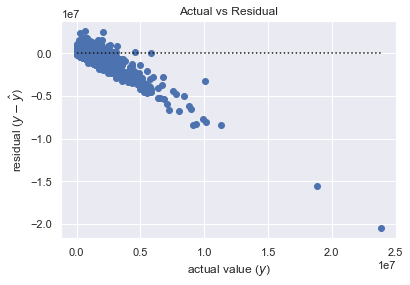

In [29]:
#Lets look at residuals
evaluate.plot_residuals(predictions.actual, predictions.ols, predictions)



# Looks like there is a clear trend. The model seems to be doing well at lower home values, but diverges significantly at higher price levels. 

In [30]:
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         assessed_value   R-squared:                       0.367
Model:                            OLS   Adj. R-squared:                  0.366
Method:                 Least Squares   F-statistic:                     2007.
Date:                Fri, 10 Apr 2020   Prob (F-statistic):               0.00
Time:                        22:16:36   Log-Likelihood:            -1.5278e+05
No. Observations:               10411   AIC:                         3.056e+05
Df Residuals:                   10407   BIC:                         3.056e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -5989.8197    2.1e+04     -0.285      0.776   -4.72e+04    3.52e+04
bedrooms    -1.465e+05   8045.351    -18.211      0.000   -1.62e+05   -1.31e+05
bathrooms    5.748e+04    1.1e+04      5.220      0.000    3.59e+04    7.91e+04
square_feet   465.3172     11.199     41.549      0.000     443.364     487.270
==============================================================================
Omnibus:                    16670.764   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         26785887.300
Skew:                          10.040   Prob(JB):                         0.00
Kurtosis:                     250.679   Cond. No.                     8.51e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.51e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Since my p-value is <0.05, I can reject my null hypothesis.
# This means that there is statistically significant relationship between home prices and  independent variables used above.

-------------------------------

# Lets apply this model on test data and see how it performs

In [31]:
y_test['y_ols'] = ols_model.predict(X_test)

In [32]:
y_test.apply(lambda col: median_absolute_error(y_test.assessed_value, col))

assessed_value        0.000
y_ols            192265.741
dtype: float64

# The Median Absolute Error for test data is comparable to train data which means that model is not overfitted

-----------------------------------------------------

(8.0, 26.0)

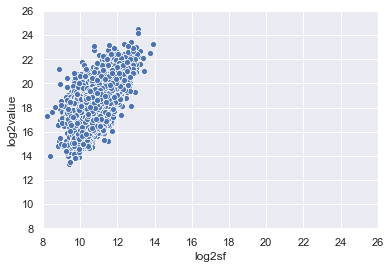

In [33]:
fig, ax = plt.subplots()
sns.scatterplot(x='log2sf', y = 'log2value', data=train, ax = ax)
ax.set_xlim(8,26)
ax.set_ylim(8,26)

(8.0, 26.0)

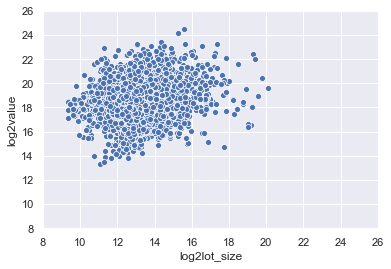

In [34]:
fig, ax = plt.subplots()
sns.scatterplot(x='log2lot_size', y = 'log2value', data=train)
ax.set_xlim(8,26)
ax.set_ylim(8,26)

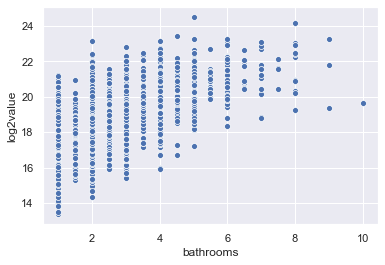

In [35]:
sns.scatterplot(x='bathrooms', y = 'log2value', data=train)

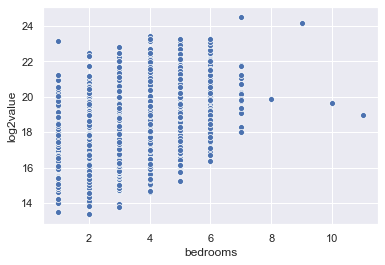

In [36]:
sns.scatterplot(x='bedrooms', y = 'log2value', data=train)

# May be we should try to fit a polynomial function to predict price using log2sf

In [37]:
X_train = train[[ 'log2sf', 'bathrooms']]
y_train = train[['log2value']]
X_test = test[['log2sf', 'bathrooms']]
y_test = test[['log2value']]

In [38]:
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_train)
poly.get_feature_names()

['1', 'x0', 'x1', 'x0^2', 'x0 x1', 'x1^2']

In [39]:
X_poly[1]

array([  1.        ,  10.73555602,   2.        , 115.25216314,
        21.47111205,   4.        ])

In [40]:
lm_poly = LinearRegression()
lm_poly.fit(X_poly, y_train)
y_train['log_predicted_poly'] = lm_poly.predict(X_poly)

In [41]:
y_train['actual'] = 2**y_train.log2value
y_train['poly_predicted'] = 2**y_train.log_predicted_poly
#y_train['median_bl'] =  train['assessed_value'].median()

In [42]:
y_train.head(2)

,log2value,log_predicted_poly,actual,poly_predicted
11938,18.035,18.723,268557.000,432772.891
790,16.548,18.230,95849.000,307510.340


In [43]:
y_train.apply(lambda col: median_absolute_error(y_train.actual, col))

log2value            389591.428
log_predicted_poly   389592.073
actual                    0.000
poly_predicted       171567.040
dtype: float64

In [44]:
y_train.apply(lambda col: r2_score(y_train.actual, col))

log2value            -0.573
log_predicted_poly   -0.573
actual                1.000
poly_predicted        0.295
dtype: float64

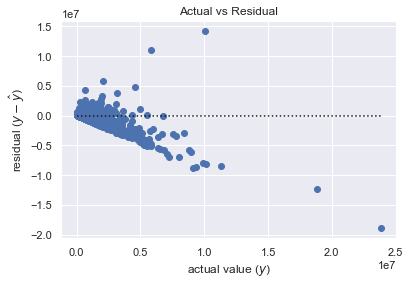

In [45]:
evaluate.plot_residuals(y_train.actual, y_train.poly_predicted, y_train)

# Polynomial Linear  Regression Summary:
# Median Absolute Error: 171,557
# R2 value: 0.295

# Generalized Additive Model (GAM)

In [125]:
train, test = train_test_split(df, train_size = .70, random_state = 123)

In [234]:
X_train = train[['bathrooms', 'square_feet', 'zip_median']]
y_train = train[['assessed_value']]
X_test = test[[ 'bathrooms', 'square_feet','zip_median']]
y_test = test[['assessed_value']]

In [235]:
#scaler, X_train_scaled, X_test_scaled = split_scale.min_max_scaler(X_train, X_test)

In [236]:
X_test= X_test.to_numpy()
y_test = y_test.to_numpy()

In [237]:
y_train

,assessed_value
1969,471862.000
11174,233507.000
7468,98324.000
6287,286277.000
11360,70158.000
...,...
5218,653066.000
12252,59793.000
1346,128781.000
11646,394607.000


In [238]:
from pygam import LinearGAM, s, f, te
gam = LinearGAM(s(0) +s(1) +s(2))

In [239]:
gam.gridsearch(X_test,y_test)

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + s(1) + s(2) + intercept, 
   tol=0.0001, verbose=False)

In [240]:
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     49.7227
Link Function:                     IdentityLink Log Likelihood:                                -119876.637
Number of Samples:                         4462 AIC:                                           239854.7194
                                                AICc:                                          239855.9091
                                                GCV:                                     189456639207.8219
                                                Scale:                                   185660236665.1148
                                                Pseudo R-Squared:                                   0.6486
Feature Function                  Lam

In [241]:
y_pred = gam.predict(X_test)

In [242]:
y_pred

array([933490.67867862, 372770.27345231, 314311.66849432, ...,
       584748.8131613 , 843241.66846287, 405477.15100978])

In [243]:
y_pred = pd.DataFrame(y_pred)

In [244]:
y_pred['actual'] =y_test

In [245]:
y_pred.head(2)

,0,actual
0,933490.679,127320.000
1,372770.273,576498.000


In [246]:
#y_pred['actual1'] = 2**y_pred.actual
#y_pred['predicted1'] = 2**y_pred[0]

In [247]:
y_pred['residual'] = y_pred.actual-y_pred[0]

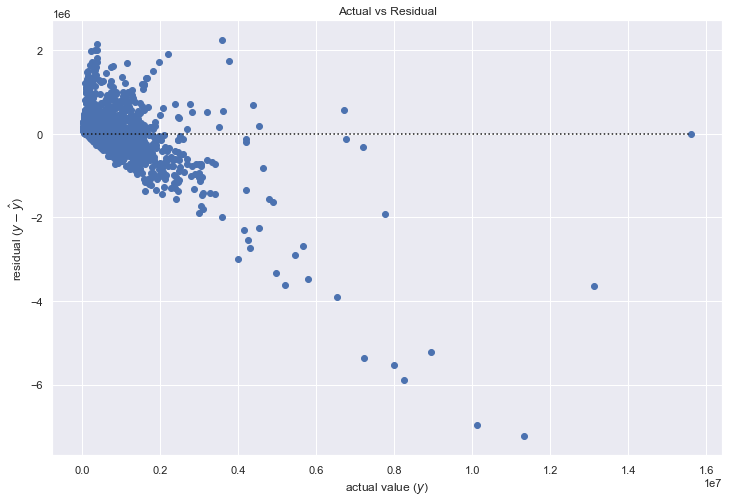

In [248]:
evaluate.plot_residuals(y_pred.actual, y_pred[0], y_pred)

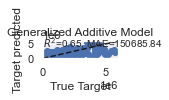

In [249]:
f, (ax1) = plt.subplots(1, 1)


ax1.scatter(y_test, y_pred[0])
ax1.plot([0, 6000000], [0, 6000000], '--k')
ax1.set_ylabel('Target predicted')
ax1.set_xlabel('True Target')
ax1.set_title('Generalized Additive Model')
ax1.text(1, 4000000, r'$R^2$=%.2f, MAE=%.2f' % (
    r2_score(y_test, y_pred[0]), median_absolute_error(y_test, y_pred[0])))
ax1.set_xlim([0, 6000000])
ax1.set_ylim([0, 6000000])

f.tight_layout(rect=[0.8, 0.8, 0.95, 0.95])

plt.show()

In [250]:
y_pred.apply(lambda col: median_absolute_error(y_pred.actual, col))

0          150685.841
actual          0.000
residual   377239.664
dtype: float64

In [251]:
y_pred.apply(lambda col: r2_score(y_pred.actual, col))

0           0.649
actual      1.000
residual   -0.193
dtype: float64

# GAM Summary with test data
# Median Absolute Error: 150,685
# R2 value: 0.649

In [252]:

# i=2
# XX = gam.generate_X_grid(term=i)
# XX[:, i]
# #ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))

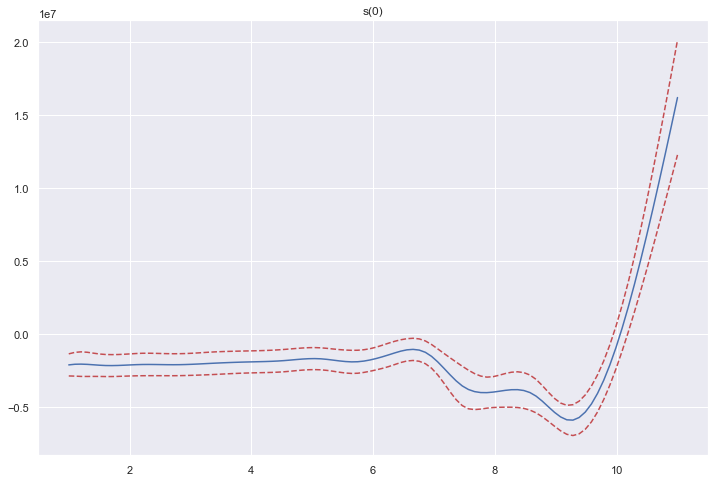

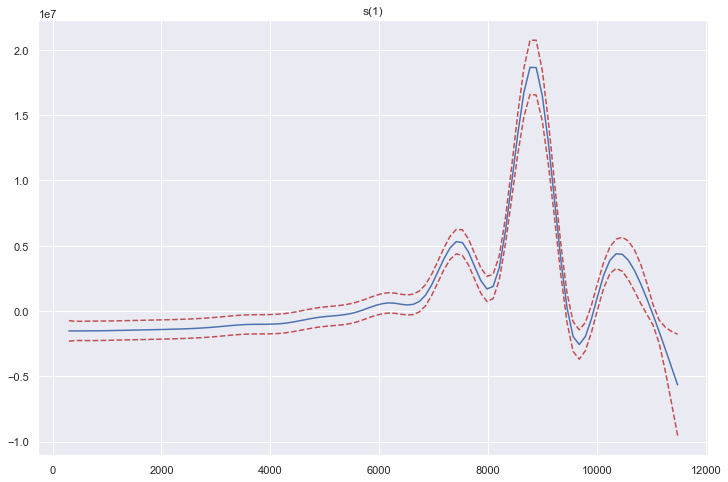

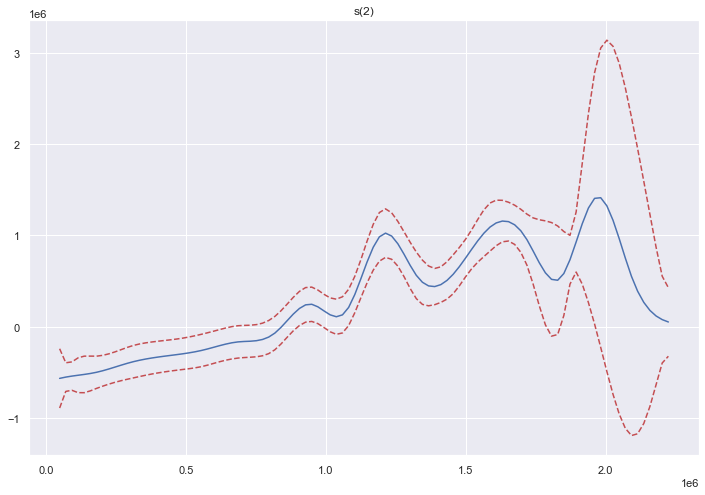

In [253]:
# Lets plot partial dependence plots for each variable
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue
    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)
    plt.figure()
    plt.plot(XX[:, term.feature], pdep)
    plt.plot(XX[:, term.feature], confi, c='r', ls='--')
    plt.title(repr(term))
    plt.show()

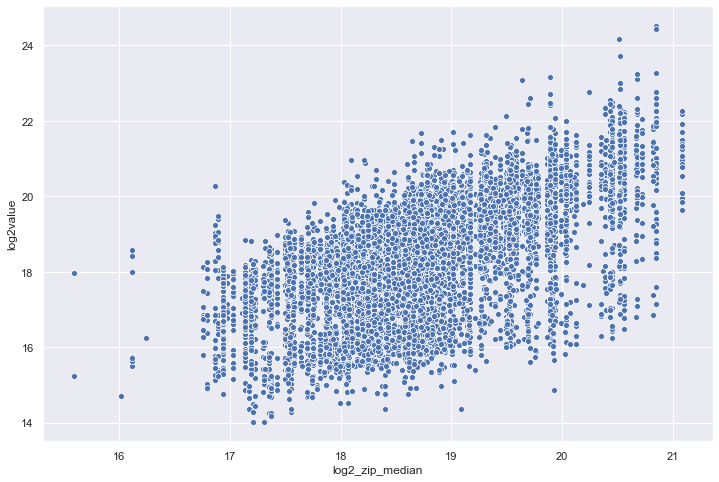

In [215]:
sns.scatterplot(x='log2_zip_median', y = 'log2value', data=train)

# Lets try a polynomial linear model with X_train = train[['bathrooms', 'log2sf', 'latitude', 'longitude', 'log2_zip_median']]

In [72]:
X_train = train[['bathrooms', 'log2sf', 'latitude', 'longitude', 'log2_zip_median']]
y_train = train[['log2value']]
X_test = test[[ 'bathrooms', 'log2sf','latitude', 'longitude', 'log2_zip_median']]
y_test = test[['assessed_value']]

In [73]:
# X_train = train[['bathrooms', 'log2sf', 'log2_zip_median','latitude', 'longitude']]
# y_train = train[['assessed_value']]
# X_test = test[[ 'bathrooms', 'log2sf','log2_zip_median','latitude', 'longitude']]
# y_test = test[['assessed_value']]

In [74]:
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_train)
poly.get_feature_names()

['1',
 'x0',
 'x1',
 'x2',
 'x3',
 'x4',
 'x0^2',
 'x0 x1',
 'x0 x2',
 'x0 x3',
 'x0 x4',
 'x1^2',
 'x1 x2',
 'x1 x3',
 'x1 x4',
 'x2^2',
 'x2 x3',
 'x2 x4',
 'x3^2',
 'x3 x4',
 'x4^2']

In [75]:
X_poly = pd.DataFrame(poly.transform(X_train), columns=poly.get_feature_names(X_train.columns))
X_poly.head(2)

,1,bathrooms,log2sf,latitude,longitude,log2_zip_median,bathrooms^2,bathrooms log2sf,bathrooms latitude,bathrooms longitude,...,log2sf^2,log2sf latitude,log2sf longitude,log2sf log2_zip_median,latitude^2,latitude longitude,latitude log2_zip_median,longitude^2,longitude log2_zip_median,log2_zip_median^2
0,1.000,2.000,10.808,34112268.000,-117736579.000,18.780,4.000,21.616,68224536.000,-235473158.000,...,116.816,368690842.759,-1272515756.943,202.977,1163646828103824.000,-4016261736251172.000,640626692.314,13861902034623240.000,-2211087083.659,352.687
1,1.000,1.000,9.585,33890131.000,-117990185.000,18.271,1.000,9.585,33890131.000,-117990185.000,...,91.872,324835634.780,-1130931498.678,175.126,1148540979197161.000,-3998702826364235.000,619204579.646,13921683756334224.000,-2155791693.613,333.827


In [76]:
lm_poly = LinearRegression()
lm_poly.fit(X_poly, y_train)
y_train['log_predicted_poly'] = lm_poly.predict(X_poly)

In [77]:
y_train.head()

,log2value,log_predicted_poly
1969,18.848,18.231
11174,17.833,17.532
7468,16.585,18.544
6287,18.127,17.498
11360,16.098,17.740


In [78]:
y_train['actual'] = 2**y_train.log2value
y_train['poly_predicted'] = 2**y_train.log_predicted_poly
#y_train['median_bl'] =  train['log2value'].median()

In [79]:
y_train.head(2)

,log2value,log_predicted_poly,actual,poly_predicted
1969,18.848,18.231,471862.000,307608.705
11174,17.833,17.532,233507.000,189476.476


In [80]:
y_train.apply(lambda col: median_absolute_error(y_train.actual, col))

log2value            385774.443
log_predicted_poly   385775.617
actual                    0.000
poly_predicted       150674.243
dtype: float64

In [81]:
y_train.apply(lambda col: r2_score(y_train.actual, col))

log2value            -0.543
log_predicted_poly   -0.543
actual                1.000
poly_predicted        0.494
dtype: float64

# Polynomial Linear  Regression Summary:
# Median Absolute Error: 151,660
# R2 value: 0.463

-----------------------------------------------------

# Lets try Ridge Regressions with cross-validation

In [82]:
train, test = train_test_split(df, train_size = .70, random_state = 100)

In [83]:
X_train = train[[ 'log2sf','log2_zip_median']]
y_train = train[['log2value']]
X_test = test[['log2sf','log2_zip_median']]
y_test = test[['log2value']]

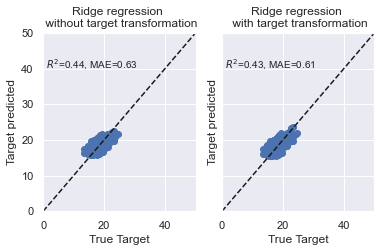

In [84]:
f, (ax0, ax1) = plt.subplots(1, 2, sharey=True)

regr = RidgeCV()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_train)

ax0.scatter(y_train, y_pred)
ax0.plot([0, 50], [0, 50], '--k')
ax0.set_ylabel('Target predicted')
ax0.set_xlabel('True Target')
ax0.set_title('Ridge regression \n without target transformation')
ax0.text(1, 40, r'$R^2$=%.2f, MAE=%.2f' % (
    r2_score(y_train, y_pred), median_absolute_error(y_train, y_pred)))
ax0.set_xlim([0, 50])
ax0.set_ylim([0, 50])

regr_trans = TransformedTargetRegressor(
    regressor=RidgeCV(),
    transformer=QuantileTransformer(n_quantiles=300,
                                    output_distribution='normal'))
regr_trans.fit(X_train, y_train)
y_pred = regr_trans.predict(X_train)

ax1.scatter(y_train, y_pred)
ax1.plot([0, 50], [0, 50], '--k')
ax1.set_ylabel('Target predicted')
ax1.set_xlabel('True Target')
ax1.set_title('Ridge regression \n with target transformation')
ax1.text(1, 40, r'$R^2$=%.2f, MAE=%.2f' % (
    r2_score(y_train, y_pred), median_absolute_error(y_train, y_pred)))
ax1.set_xlim([0, 50])
ax1.set_ylim([0, 50])

f.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])

plt.show()

In [85]:
y_pred = pd.DataFrame(y_pred, columns = ['predicted_log'],index=y_train.index)

In [86]:
y_pred.head(2)

,predicted_log
11938,18.232
790,18.796


In [87]:
y_pred1 = train[['assessed_value']]

In [88]:
y_pred1.head(2)

,assessed_value
11938,268557.000
790,95849.000


In [89]:
df1 = pd.concat([y_pred, y_pred1], axis=1)

In [90]:
df1.head(2)

,predicted_log,assessed_value
11938,18.232,268557.000
790,18.796,95849.000


In [91]:
df1['predicted1'] = 2**df1.predicted_log

In [92]:
df1.head(2)

,predicted_log,assessed_value,predicted1
11938,18.232,268557.000,307789.244
790,18.796,95849.000,455261.012


In [93]:
df1.apply(lambda col: median_absolute_error(df1.assessed_value, col))

predicted_log    389591.474
assessed_value        0.000
predicted1       152901.407
dtype: float64

In [94]:
df1.apply(lambda col: r2_score(df1.assessed_value, col))

predicted_log    -0.573
assessed_value    1.000
predicted1        0.419
dtype: float64

# Ridge Regression Summary:
# Median Absolute Error: 152,901
# R2 value: 0.419

----------------------------------------

# Lets now try to remove outliers and then do modeling

In [95]:
df.head(2)

,bathrooms,bedrooms,square_feet,fips,lot_size,pool,zip_code,year_built,latitude,longitude,...,tax_value,transaction_date,tax_rate,County,log2sf,log2lot_size,log2value,age,zip_median,log2_zip_median
0,2.000,3.000,1458.000,6037,8284,1,97318,1970,34686163.000,-118113100.000,...,2319.900,2017-06-23,0.017,Los Angles,10.510,13.016,17.054,30,144172.000,17.137
1,1.000,2.000,1421.000,6037,6707,0,96018,1911,33999877.000,-118291863.000,...,543.690,2017-06-30,0.015,Los Angles,10.473,12.711,15.120,89,162337.000,17.309


In [96]:
train, test = train_test_split(df, train_size = .70, random_state = 100)

In [97]:
train = train[train.assessed_value< 1000000]

In [98]:
#train_plot = train[['bathrooms', 'bedrooms', 'square_feet', 'assessed_value', 'lot_size']]

In [99]:
#explore.plot_variable_pairs(train_plot)

In [100]:
#bath_cutoff = train.bathrooms.mean() + 3*train.bathrooms.std()

In [101]:
#bed_cutoff = train.bedrooms.mean() + 3*train.bedrooms.std()

In [102]:
#sf_cutoff = train.square_feet.mean() + 3*train.square_feet.std()

In [103]:
#bath_cutoff, bed_cutoff , sf_cutoff

In [104]:
#train = train[train.bathrooms<bath_cutoff][train.bedrooms<bed_cutoff][train.square_feet<sf_cutoff]

In [105]:
#train.assessed_value.max()

In [106]:
#outliers = train[train.assessed_value>1000000]

In [107]:
#outliers.info()

In [108]:
#outliers_plot = outliers[['bathrooms', 'bedrooms', 'square_feet', 'assessed_value', 'lot_size']]

In [109]:
#explore.plot_variable_pairs(outliers_plot)

In [110]:
X_train = train[['bedrooms', 'bathrooms', 'log2sf']]
y_train = train[['log2value']]
X_test = test[['bedrooms', 'bathrooms', 'log2sf']]
y_test = test[['log2value']]

In [111]:
predictions = pd.DataFrame({
    'actual_log': y_train.log2value
})
predictions.head(2)

,actual_log
11938,18.035
790,16.548


In [112]:
#We now create a OLS model based on bedrooms, bathrooms and square_feet
from statsmodels.formula.api import ols

# generate parameters, i.e. create model
ols_model = ols('log2value ~ bedrooms + bathrooms + log2sf', data = train).fit()

# compute predictions and add to original dataframe
predictions['ols_log'] = ols_model.predict(X_train)

In [113]:
predictions['actual'] = 2**predictions.actual_log
predictions['ols_predicted'] = 2**predictions.ols_log

In [114]:
(2**y_train.log2value).mean()

377045.96587841486

In [115]:
predictions.head()

,actual_log,ols_log,actual,ols_predicted
11938,18.035,18.664,268557.000,415383.095
790,16.548,18.035,95849.000,268547.775
3846,18.308,18.380,324613.000,341233.328
14846,18.931,18.785,499860.000,451642.276
1469,18.982,17.947,517777.000,252628.507


In [116]:
pd.options.display.float_format = '{:.3f}'.format
predictions.apply(lambda col: median_absolute_error(predictions.actual, col))

actual_log      344368.606
ols_log         344368.530
actual               0.000
ols_predicted   156431.636
dtype: float64

In [117]:
predictions.apply(lambda col: sqrt(mean_squared_error(predictions.actual, col)))

actual_log      446394.657
ols_log         446395.111
actual               0.000
ols_predicted   223132.376
dtype: float64

In [118]:
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log2value   R-squared:                       0.179
Model:                            OLS   Adj. R-squared:                  0.179
Method:                 Least Squares   F-statistic:                     672.6
Date:                Fri, 10 Apr 2020   Prob (F-statistic):               0.00
Time:                        22:16:48   Log-Likelihood:                -13684.
No. Observations:                9261   AIC:                         2.738e+04
Df Residuals:                    9257   BIC:                         2.740e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.0172      0.337     29.725      0.000       9.357      10.678
bedrooms      -0.1616      0.017     -9.469      0.000      -0.195      -0.128
bathrooms      0.2218      0.024      9.389      0.000       0.176       0.268
log2sf         0.7657      0.036     21.006      0.000       0.694       0.837
==============================================================================
Omnibus:                      629.231   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              731.158
Skew:                          -0.671   Prob(JB):                    1.70e-159
Kurtosis:                       2.697   Cond. No.                         352.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [119]:
predictions2 = pd.DataFrame({
    'actual_log': y_test.log2value
})
predictions2.head(2)

,actual_log
9116,20.367
2397,19.605


In [120]:
predictions2['test_ols_log'] = ols_model.predict(X_test)

In [121]:
predictions2['actual'] = 2**predictions2.actual_log
predictions2['test_ols_predicted'] = 2**predictions2.test_ols_log

In [122]:
predictions2.head(2)

,actual_log,test_ols_log,actual,test_ols_predicted
9116,20.367,18.978,1352462.000,516348.014
2397,19.605,18.839,797339.000,468927.282


In [123]:
predictions2.apply(lambda col: median_absolute_error(predictions2.actual, col))

actual_log           371192.998
test_ols_log         371193.006
actual                    0.000
test_ols_predicted   171045.651
dtype: float64

In [124]:
2**y_test.log2value.median()

371211.4694914477